In [1]:
import math
import numpy as np
import finite
import matplotlib.pyplot as plt
import scipy

class Timestepper:

    def __init__(self, u, f):
        self.t = 0
        self.iter = 0
        self.u = u
        self.func = f
        self.dt = None

    def step(self, dt):
        self.u = self._step(dt)
        self.t += dt
        self.iter += 1
        
    def evolve(self, dt, time):
        while self.t < time - 1e-8:
            self.step(dt)

class ForwardEuler(Timestepper):

    def _step(self, dt):
        return self.u + dt*self.func(self.u)


class LaxFriedrichs(Timestepper):

    def __init__(self, u, f):
        super().__init__(u, f)
        N = len(u)
        A = sparse.diags([1/2, 1/2], offsets=[-1, 1], shape=[N, N])
        A = A.tocsr()
        A[0, -1] = 1/2
        A[-1, 0] = 1/2
        self.A = A

    def _step(self, dt):
        return self.A @ self.u + dt*self.func(self.u)


class Leapfrog(Timestepper):

    def _step(self, dt):
        if self.iter == 0:
            self.u_old = np.copy(self.u)
            return self.u + dt*self.func(self.u)
        else:
            u_temp = self.u_old + 2*dt*self.func(self.u)
            self.u_old = np.copy(self.u)
            return u_temp


class LaxWendroff(Timestepper):

    def __init__(self, u, func1, func2):
        self.t = 0
        self.iter = 0
        self.u = u
        self.f1 = func1
        self.f2 = func2

    def _step(self, dt):
        return self.u + dt*self.f1(self.u) + dt**2/2*self.f2(self.u)


class Multistage(Timestepper):

    def __init__(self, u, f, stages, a, b):
        super().__init__(u, f)   #Sets self.t = 0
        self.stages=stages       #self.iter = 0
        self.a=a                 #self.u = u
        self.b=b                 #self.func = f
                                 #self.dt = None
        pass
    def _step(self, dt):
        N=len(self.u)
        k=np.zeros((self.stages, N))
        i=0
        while i<self.stages:
            #print("k: ", k)
            k[i]=self.func(self.u + dt*self.a[i] @ k)
            i+=1
        return self.u + dt*self.b @ k

class AdamsBashforth(Timestepper):

    def __init__(self, u, f, steps, dt):
        self.t = 0
        self.iter = 0
        self.func = f
        self.dt = dt
        self.u=np.zeros((steps,len(u)))
        self.u[0]=u
        #print("initialization: ", self.u)
        self.steps=steps
        r=np.zeros((steps,steps))
        w=np.zeros((steps,steps))
        j=1
        while j<=steps:
            b=np.zeros((j,j))
            b[0]=np.ones(j)
            i=1
            while i<j:
                b[i]=(-1)**i/math.factorial(i)*np.arange(j)**i
                i+=1
            r[j-1][:j]=scipy.special.factorial(np.arange(1,j+1))**(-1)
            w[j-1][:j]=np.linalg.inv(b)@r[j-1][:j]
            j+=1
        self.w=w
        pass
    def _step(self, dt):
        steps=self.steps
        if steps<=1:
            steps=1
            isstepsIndex=0
        else:
            isstepsIndex=1
        iters=self.iter
        #print("iteration: ", iters)
        u=self.u
        #print("a: ",type(u[0]))
        w=self.w
        N=len(u[0])

        BONUS=np.zeros(N)
        if iters>=steps:
            i=0
            while i<steps:
                BONUS=BONUS+w[steps-1,i]*self.func(u[i])
                i+=1
        else:
            i=0
            while i<=iters:
                BONUS=BONUS+w[iters,i]*self.func(u[i])
                i+=1
        u=np.roll(u,1, axis=0)
        u[0]=u[isstepsIndex]+dt*BONUS
        self.u=u
        #print("b: ", self.u[0])
        #print("c: ", type(u[0]))
        return self.u
    
def plot_2D(matrix, title='FD matrix'):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.title(title)
    plt.tight_layout()

0.01
0.007638470872337044
True


C:\Users\Owner\AppData\Local\Temp/ipykernel_3500/2519507234.py:152: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


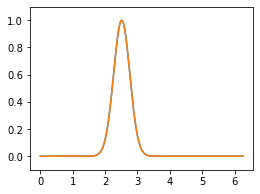

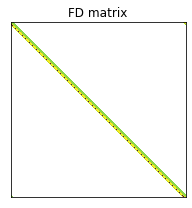

In [14]:
resolution_list = [100, 200, 400]
ITER=2
error_RK_2_2 = {100:0.15, 200:0.05, 400:0.01}
#print(error_RK_2_2)
#@pytest.mark.parametrize('resolution', resolution_list)
#def test_RK_2_2(resolution):
    
grid = finite.UniformPeriodicGrid(resolution_list[ITER], 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)
alpha = 0.1
dt = alpha*grid.dx
target = np.exp(-(x-np.pi+2*np.pi*0.1)**2*8)

d = finite.DifferenceUniformGrid(1, 8, grid)
f = lambda u: d @ u

steps=3
    
ts = AdamsBashforth(IC, f, steps, dt)


num_periods = 6.1
ts.evolve(dt, 2*np.pi*num_periods)

error = np.max(np.abs(ts.u - target))
error_est = error_RK_2_2[resolution_list[ITER]]
#print(type(ts.u), type(target))
#print(type(np.abs(ts.u-target)))

print(error_est)
print(error)
print(error < error_est)

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u[0])
plt.ylim([-0.1, 1.1])
fig.canvas.draw()
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u[0])
        fig.canvas.draw()
#plt.plot(x, IC)
plt.plot(x, target)
plot_2D(d.matrix.A)

w:  [[ 1.   0. ]
 [ 1.5 -0.5]]


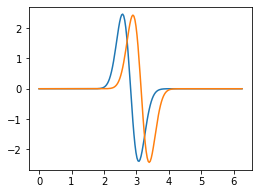

In [118]:

#Runs okay
steps=2
if steps<1:
    steps=1
r=np.zeros((steps,steps))
w=np.zeros((steps,steps))
j=1
while j<=steps:
    b=np.zeros((j,j))
    b[0]=np.ones(j)
    i=1
    while i<j:
        b[i]=(-1)**i/math.factorial(i)*np.arange(j)**i
        i+=1
    r[j-1][:j]=scipy.special.factorial(np.arange(1,j+1))**(-1)
    w[j-1][:j]=np.linalg.inv(b)@r[j-1][:j]
    j+=1
print("w: ", w)


#Needs checked
iters=0
grid = finite.UniformPeriodicGrid(200, 2*np.pi)
dt = 0.1*grid.dx
x = grid.values
u0 = np.exp(-(x-np.pi)**2*8)
u0prime = -16*(x-np.pi)*np.exp(-(x-np.pi)**2*8)
u=np.zeros((steps,len(u0)))
u[0]=u0

target = np.exp(-(u0-np.pi-2*np.pi*0.2)**2*8)
d = finite.DifferenceUniformGrid(1, 28, grid)
#plot_2D(d.matrix.A)
func = lambda u: d @ u

###Start do NOT include####
TimeSteps=8100
while iters<=TimeSteps:
###End ###
    BONUS=np.zeros(200)
    if iters>=steps:
        i=0
        while i<steps:
            #print(BONUS[80],"+",w[steps-1,i],"*",func(u[i])[80],"=")
            BONUS=BONUS+w[steps-1,i]*func(u[i])
            #print(BONUS[80])
            i+=1
    else:
        i=0
        while i<=iters:
            #print(BONUS[80],"+",w[iters,i],"*",func(u[i])[80],"=")
            BONUS=BONUS+w[iters,i]*func(u[i])
            #print(BONUS[80])
            i+=1
    u=np.roll(u,1, axis=0)
    if steps<=1:
        u[0]=u[0]+dt*BONUS
    else:
        u[0]=u[1]+dt*BONUS
    #print("u=", u[0,80], "=", u[1,80], "+", dt, "*", BONUS[80])
    #print("out: ", iters)
    ###BEgin###
    iters+=1
    ###End###
#print(u)
fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, func(u[0]))
p, = plt.plot(x, u0prime)
#p, = plt.plot(x,u[steps-2])
#p, = plt.plot(x,u[1])
#p, = plt.plot(x,u0prime-func(u[0]))

#plt.ylim([-0.1, 1.1])
fig.canvas.draw()
#p.set_ydata(u[steps-1])
fig.canvas.draw()

In [32]:
w

array([ 1.5, -0.5])

### 